# 1. Introduction
This notebook outlines the steps to convert the COCO dataset for pedestrian detection and segmentation into a structured format. The process involves:

* Filtering the dataset to retain only the "person" category.
* Storing original images and corresponding segmentation masks in separate folders.
* Splitting the dataset into three subsets: training, validation, and testing.

By applying this conversion, the COCO dataset can be used alongside the PennFudanPed dataset for pedestrian detection and segmentation tasks.

# 2. The U-Net Architecture
U-Net is one of the most common deep learning architectures for segmentation tasks. The block diagram of this model is depicted in the figure below:

<div style="text-align: center;">
    <img src="images/u-net-architecture.png" width="600"/>
</div>

The architecture features a "U" shape, consisting of two main stages: the contracting (encoder) and expansive (decoder) stages.

* The **encoder** captures the context and high-level features of the input image by using several convolutional layers. It gradually reduces the spatial dimensions while increasing the feature dimensions.

* The **decoder** is responsible for reconstructing the output image, which, in the case of segmentation, is the mask that identifies the objects of interest. This stage involves upsampling across the same number of levels as the encoder, followed by convolutional operations to "expand" the contracted image.

One of the unique characteristics of U-Net is its **skip connections**, which link the encoder and decoder stages at each level by merging features. While the contracting and expanding paths ("U" shape) capture high-level contextual information, the skip connections help preserve low-level spatial details that might be lost during downsampling.

# 2. Importing Libraries

In [1]:
# Generic libraries
import os
import torch
import json
import zipfile
import urllib
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from pathlib import Path
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

# Import custom libraries
from utils.obj_detection_utils import collate_fn
from utils.segmentation_utils import display_image_with_mask, collapse_one_hot_mask, create_label_class_dict
from engines.segmentation import SegmentationEngine
from engines.schedulers import FixedLRSchedulerWrapper
from engines.loss_functions import DiceCrossEntropyLoss
from dataloaders.segmentation_dataloaders import ProcessDatasetSegmentation, SegmentationTransforms
from models.unet import create_unet

# Import custom libraries
from utils.classification_utils import set_seeds
from utils.coco_dataset_utils import COCO_2_ImgMsk, split_dataset

# Warnings
import warnings
os.environ['TORCH_USE_CUDA_DSA'] = "1"
warnings.filterwarnings("ignore", category=UserWarning, module="torch.autograd.graph")
warnings.filterwarnings("ignore", category=FutureWarning, module="onnxscript.converter")

import torch._dynamo
#torch._dynamo.config.suppress_errors = True
torch._dynamo.config.cache_size_limit = 64
#warnings.filterwarnings("ignore", category=UserWarning, module="torch._dynamo")

# Create target model directory
MODEL_DIR = Path("outputs")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Set seeds
SEED = 42
set_seeds(SEED)

DOWNLOAD_COCO = False
PROCESS_COCO = False
VISUALIZE_TRANSFORMED_DATA = False

# 3. Specifying the Target Device

In [2]:
# Activate cuda benchmark
#cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sun Mar  9 11:46:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P8             12W /  200W |    1649MiB /  12282MiB |      8%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 2. Downloading the COCO Dataset

In [3]:
if DOWNLOAD_COCO:
    # Define download URLs
    coco_urls = {
        "val_images": "http://images.cocodataset.org/zips/val2017.zip",
        "test_images": "http://images.cocodataset.org/zips/test2017.zip",
        "train_images": "http://images.cocodataset.org/zips/train2017.zip",
        "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    }

    # Create a directory to store the dataset
    dataset_dir = "d:/Repos/coco_dataset"
    os.makedirs(dataset_dir, exist_ok=True)

    # Download function
    def download_coco(url, filename):
        filepath = os.path.join(dataset_dir, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
            print(f"Saved to {filepath}")
        else:
            print(f"{filename} already exists.")

    # Download all files
    for key, url in coco_urls.items():
        filename = url.split("/")[-1]
        download_coco(url, filename)

In [4]:
if DOWNLOAD_COCO:
    # Unzip the file
    PATH = Path(dataset_dir)
    
    zip_file = PATH / "val2017.zip"
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    if zip_file.exists():
        os.remove(zip_file)

    zip_file = PATH / "annotations_trainval2017.zip"
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    if zip_file.exists():
        os.remove(zip_file)

    zip_file = PATH / "test2017.zip"
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    if zip_file.exists():
        os.remove(zip_file)

    zip_file = PATH / "train2017.zip"
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    if zip_file.exists():
        os.remove(zip_file)

# 4. Processing the COCO Dataset for Driving Segmentation

In [5]:
if PROCESS_COCO:
    # Path to COCO annotations file
    ANNOTATIONS_PATH = r"D:\Repos\coco_dataset\annotations\instances_train2017.json"

    # Load COCO annotations
    with open(ANNOTATIONS_PATH, "r") as f:
        coco_data = json.load(f)

    # Extract category ID to name mapping
    categories = {c["id"]: c["name"] for c in coco_data["categories"]}

    # Display all categories
    for cat_id, cat_name in categories.items():
        print(f"{cat_id}: {cat_name}")

In [6]:
# Create the dictionary describing label -> category), say in alphabetical order
target_categories={
    0: 'background',
    1: 'bus',
    2: 'car',
    3: 'truck'
}
## Display categories
for cat_id, cat_name in target_categories.items():
    print(f"{cat_id}: {cat_name}")

0: background
1: bus
2: car
3: truck


In [7]:
if PROCESS_COCO:
    # Training dataset
    mapping = COCO_2_ImgMsk(
        coco_images_path=      r"D:\Repos\coco_dataset\train2017",
        coco_annotations_path= r"D:\Repos\coco_dataset\annotations\instances_train2017.json",
        output_images_dir=     r"D:\Repos\coco_dataset\driving\PNGImages",
        output_masks_dir=      r"D:\Repos\coco_dataset\driving\PedMasks",
        class_dictionary=      target_categories,
        label=                 "train"
    )

In [8]:
if PROCESS_COCO:
    # Training dataset
    _ = COCO_2_ImgMsk(
        coco_images_path=      r"D:\Repos\coco_dataset\val2017",
        coco_annotations_path= r"D:\Repos\coco_dataset\annotations\instances_val2017.json",
        output_images_dir=     r"D:\Repos\coco_dataset\driving\PNGImages",
        output_masks_dir=      r"D:\Repos\coco_dataset\driving\PedMasks",
        class_dictionary=      target_categories,
        label=                 "val"
    )

In [9]:
if PROCESS_COCO:
# Split dataset into train (80%), validation (10%), and test (10%) sets
    split_dataset(
        src_images=       r"D:\Repos\coco_dataset\driving\PNGImages",
        src_masks=        r"D:\Repos\coco_dataset\driving\PedMasks",
        dst_train_images= r"C:\Users\ssre_\Projects\torchsuite\data\driving\train\PNGImages",
        dst_train_masks=  r"C:\Users\ssre_\Projects\torchsuite\data\driving\train\PedMasks",
        dst_val_images=   r"C:\Users\ssre_\Projects\torchsuite\data\driving\val\PNGImages",
        dst_val_masks=    r"C:\Users\ssre_\Projects\torchsuite\data\driving\val\PedMasks",
        dst_test_images=  r"C:\Users\ssre_\Projects\torchsuite\data\driving\test\PNGImages",
        dst_test_masks=   r"C:\Users\ssre_\Projects\torchsuite\data\driving\test\PedMasks",
        train_pct=        0.80,
        val_pct=          0.10,
        test_pct=         0.10,
        seed=             SEED
    )

# 5. Preparing Dataloaders

In [ ]:
# The dataset contains two classes only: background and person
NUM_CLASSES = len(target_categories)
BATCH_SIZE = 4
ACCUM_STEPS = 8
IMG_SIZE = (384, 384) #(512, 512)
AUGMENT_MAGNITUDE = 4 # 1 (low) to 5 (high)

# Define training, validation, and test data loaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=ProcessDatasetSegmentation(
        root='data/driving/train',
        image_path="PNGImages",
        mask_path="PedMasks",
        transforms=SegmentationTransforms(
            train=True,
            img_size=IMG_SIZE,
            mean_std_norm=True,
            augment_magnitude=AUGMENT_MAGNITUDE
            ),
        class_dictionary=target_categories
        ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=ProcessDatasetSegmentation(
        root='data/driving/val',
        image_path="PNGImages",
        mask_path="PedMasks",
        transforms=SegmentationTransforms(
            train=False,
            img_size=IMG_SIZE,
            mean_std_norm=True,
            augment_magnitude=AUGMENT_MAGNITUDE
            ),
        class_dictionary=target_categories
        ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=ProcessDatasetSegmentation(
        root='data/driving/test',
        image_path="PNGImages",
        mask_path="PedMasks",
        transforms=SegmentationTransforms(
            train=False,
            img_size=IMG_SIZE,
            mean_std_norm=True,
            augment_magnitude=AUGMENT_MAGNITUDE
            ),
        class_dictionary=target_categories
        ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)

# 6. Visualize Images with Masks

In [11]:
if VISUALIZE_TRANSFORMED_DATA:
    # Visualize transformations
    dataloader_nt = torch.utils.data.DataLoader(
        dataset=ProcessDatasetSegmentation(
            root='data/driving/train',
            image_path="PNGImages",
            mask_path="PedMasks",
            transforms=SegmentationTransforms(
                train=False,
                img_size=IMG_SIZE,
                mean_std_norm=False,
                augment_magnitude=AUGMENT_MAGNITUDE
                ),
            class_dictionary=target_categories
            ), 
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        collate_fn=collate_fn)
    dataloader_t = torch.utils.data.DataLoader(
        dataset=ProcessDatasetSegmentation(
            root='data/driving/train',
            image_path="PNGImages",
            mask_path="PedMasks",
            transforms=SegmentationTransforms(
                train=True,
                img_size=IMG_SIZE,
                mean_std_norm=False,
                augment_magnitude=AUGMENT_MAGNITUDE
                ),
            class_dictionary=target_categories
            ), 
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        collate_fn=collate_fn)
    
    for idx, ((img_nt, target_nt), (img_t, target_t)) in enumerate(zip(dataloader_nt, dataloader_t)):   
        for i in range(0, BATCH_SIZE):

            # Set up the figure
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Pass subplot axes to the function
            print(type(img_nt))
            mask_nt = collapse_one_hot_mask(target_nt[i])
            mask_t = collapse_one_hot_mask(target_t[i])

            # Create the label-class dictionary for the mask
            classes_nt = create_label_class_dict(target_nt[i], target_categories)
            classes_t = create_label_class_dict(target_t[i], target_categories)

            # And generate the titles
            title_nt = f"Original: {', '.join(classes_nt.values())}"
            title_t = f"Transformed: {', '.join(classes_t.values())}"
            
            # Display overlaid images
            display_image_with_mask(img_nt[i], mask_nt, ax=axes[0], alpha=0.5, cmap='YlGnBu', title=title_nt)
            display_image_with_mask(img_t[i], mask_t, ax=axes[1], alpha=0.5, cmap='YlOrRd', title=title_t)
            
            plt.show() 
            
        if idx > 4:
            break

# 7. Creating the U-Net Architecture

In [12]:
# Instantiate the model
model = create_unet(
    model_type="pretrained",
    backbone='convnext_large_384_in22ft1k', #'convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES,
    print_available_models=False,
    pretrained=True,
    encoder_freeze=False
)

# Unfreeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = True

# Compile model
model = torch.compile(model, backend="aot_eager")

#summary(model,
#        input_size=(BATCH_SIZE,3, IMG_SIZE[0], IMG_SIZE[1]),
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

Cloning https://github.com/mberkay0/pretrained-backbones-unet.git...
Repository cloned successfully.
Model ``pretrained`` created sucessfully!


# 8. Training the Model

Epoch: 3/30 | Train: | loss: 0.5052 | dice: 0.4522 | iou: 0.4200 | time:  19m47s | lr: 0.0000989183
Epoch: 3/30 | Test:  | loss: 0.4119 | dice: 0.6522 | iou: 0.6218 | time:   1m16s | lr: 0.0000989183


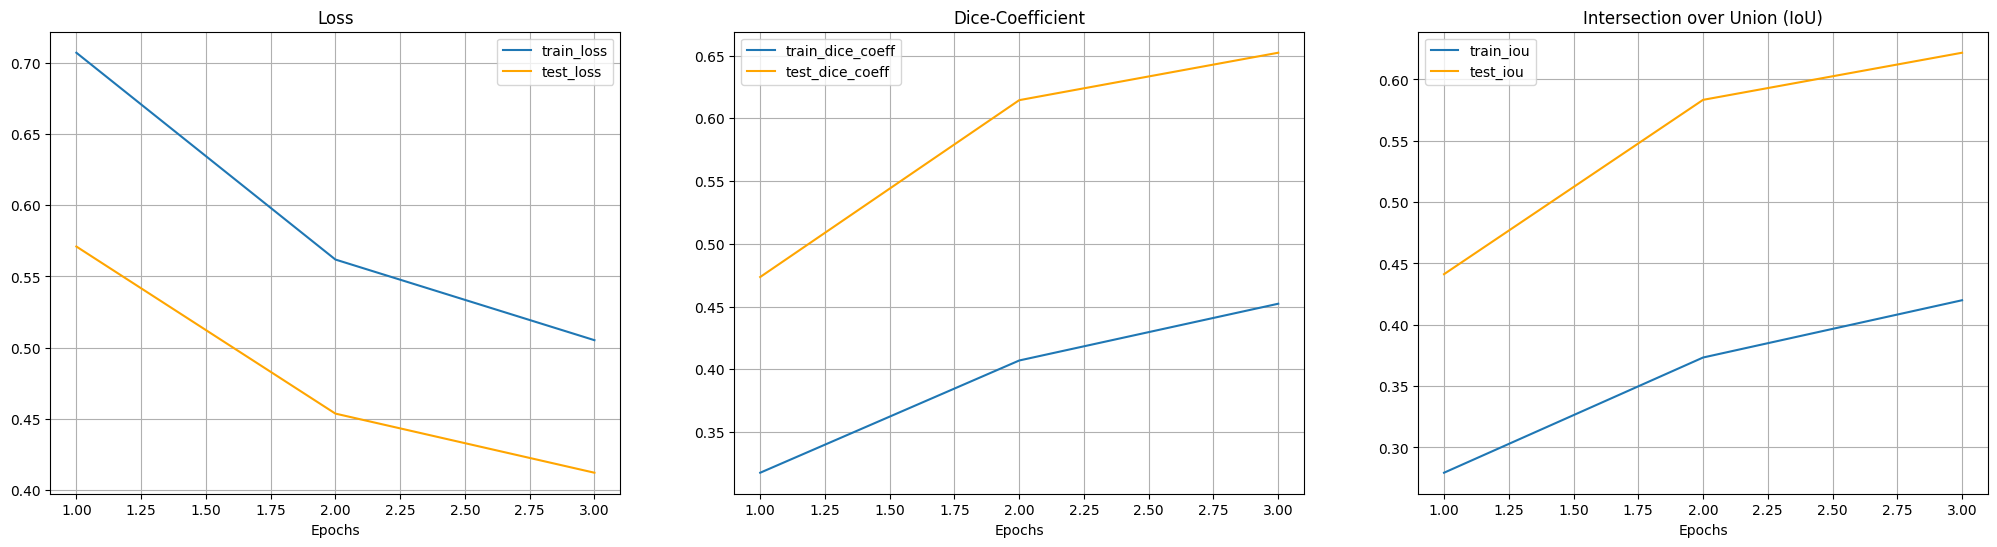

[INFO] Saving model to: outputs\model_seg2_epoch3.pth
[INFO] Saving model to: outputs\model_seg2_dice_epoch3.pth
[INFO] Training epoch 4...


  0%|          | 0/3396 [00:00<?, ?it/s]

In [ ]:
# Train the model
EPOCHS = 30
LR = 1e-4
model_type="model_seg2"
model_name = model_type + ".pth"

torch.cuda.empty_cache()

# Create AdamW optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=1e-4
    )

# Create loss function
#loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
loss_fn = DiceCrossEntropyLoss(
    num_classes=NUM_CLASSES,
    label_smoothing=0.1
    )

# Set scheduler
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=EPOCHS
    )

# Set seeds
set_seeds(SEED)

# And train...

# Instantiate the classification engine with the created model and the target device
engine = SegmentationEngine(
    model=model,    
    log_verbose=True,
    device=device
    )

# Configure the training method
results = engine.train(
    target_dir=MODEL_DIR,                       # Directory where the model will be saved
    model_name=model_name,                      # Name of the model
    save_best_model=["last", "dice"],           # Save the best models based on different criteria
    keep_best_models_in_memory=False,           # Do not keep the models stored in memory for the sake of training time and memory efficiency
    train_dataloader=train_dataloader,          # Train dataloader
    test_dataloader=val_dataloader,             # Validation/test dataloader
    num_classes=NUM_CLASSES,                    # Number of classes
    optimizer=optimizer,                        # Optimizer
    loss_fn=loss_fn,                            # Loss function    
    scheduler=scheduler,                        # Scheduler
    epochs=EPOCHS,                              # Total number of epochs
    accumulation_steps=ACCUM_STEPS              # Accumulation steps: effective batch size = batch_size x accumulation steps
    )